In [65]:
pip install numpy opencv-python pywavelets matplotlib


In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [67]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [68]:
def block_fft_homomorphic_filtering(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)

    # Separate frequency components
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    # High-pass filter
    high_pass = np.copy(magnitude_spectrum)
    high_pass[crow-50:crow+50, ccol-50:ccol+50] = 0

    # Apply homomorphic filtering on the high-frequency components
    filtered_high_pass = homomorphic_filter(high_pass)

    # Inverse FFT on the filtered image
    filtered_high_pass_shifted = np.fft.ifftshift(filtered_high_pass)
    filtered_image = np.exp(np.real(np.fft.ifft2(filtered_high_pass_shifted)))

    # Combine low and high frequency components
    combined_image = np.copy(fshift)
    combined_image[crow-50:crow+50, ccol-50:ccol+50] = np.fft.fft2(filtered_image)

    # Convert back to spatial domain
    enhanced_image = np.real(np.fft.ifft2(np.fft.ifftshift(combined_image)))
    enhanced_image = np.exp(enhanced_image - 1)
    enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX)

    return np.uint8(enhanced_image)


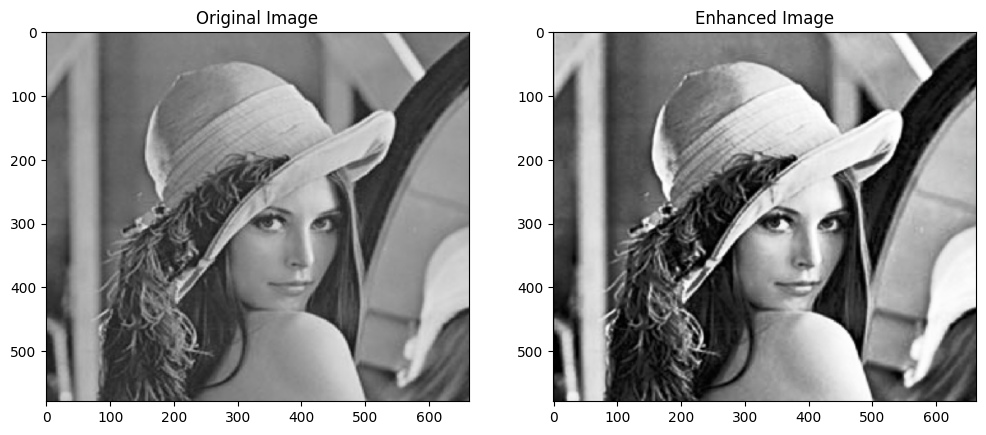

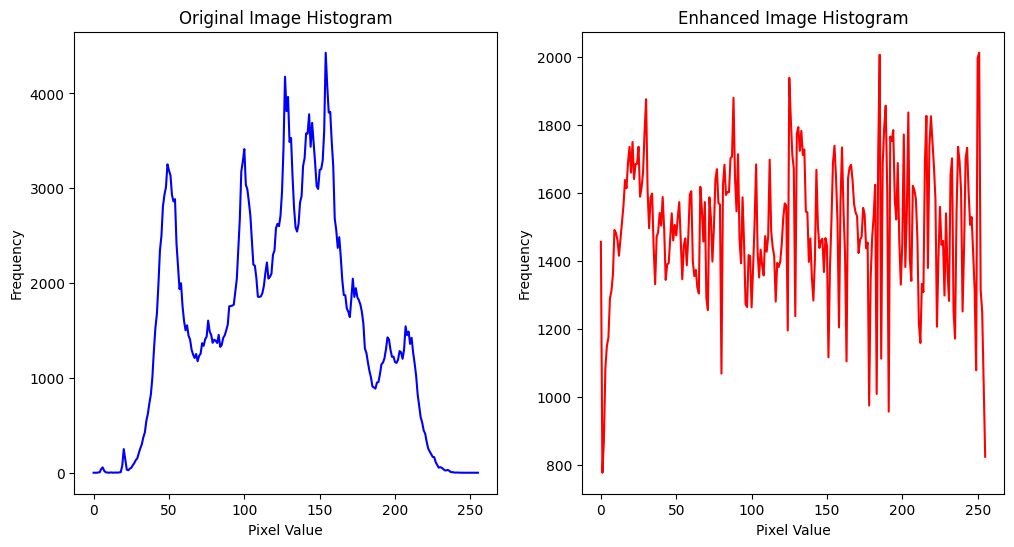

In [69]:
import cv2
import pywt
import matplotlib.pyplot as plt

def block_fft_homomorphic_filtering(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)

    # Separate frequency components
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    # High-pass filter
    high_pass = np.copy(magnitude_spectrum)
    high_pass[crow-50:crow+50, ccol-50:ccol+50] = 0

    # Apply homomorphic filtering on the high-frequency components
    filtered_high_pass = homomorphic_filter(high_pass)

    # Inverse FFT on the filtered image
    filtered_high_pass_shifted = np.fft.ifftshift(filtered_high_pass)
    filtered_image = np.exp(np.real(np.fft.ifft2(filtered_high_pass_shifted)))

    # Combine low and high frequency components
    combined_image = np.copy(fshift)
    combined_image[crow-50:crow+50, ccol-50:ccol+50] = np.fft.fft2(filtered_image)

    # Convert back to spatial domain
    enhanced_image = np.real(np.fft.ifft2(np.fft.ifftshift(combined_image)))
    enhanced_image = np.exp(enhanced_image - 1)
    enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX)

    return np.uint8(enhanced_image)


def homomorphic_filter(image, gammaH=1.5, gammaL=0.5, c=1, D0=30):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    X, Y = np.meshgrid(np.arange(cols) - ccol, np.arange(rows) - crow)
    D = np.sqrt(X**2 + Y**2)
    H = (gammaH - gammaL) * (1 - np.exp(-c * (D**2 / D0**2))) + gammaL

    img_fft = np.fft.fft2(image)
    img_fft_filtered = img_fft * H

    img_filtered = np.real(np.fft.ifft2(img_fft_filtered))

    # Normalize to avoid overflow in exponential operation
    img_filtered = np.exp(img_filtered)
    img_filtered = cv2.normalize(img_filtered, None, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(img_filtered)


def rgb2hsi(rgb_image):
    rgb_image = rgb_image.astype(np.float32) / 255.0
    r, g, b = cv2.split(rgb_image)
    intensity = np.mean(rgb_image, axis=2)

    min_value = np.min(rgb_image, axis=2)
    saturation = 1 - 3 * min_value / (r + g + b + 1e-6)

    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g)**2 + (r - b) * (g - b))
    theta = np.arccos(num / (den + 1e-6))
    hue = np.where(b > g, 2 * np.pi - theta, theta) / (2 * np.pi)

    hsi_image = cv2.merge([hue, saturation, intensity])
    return hsi_image

def hsi2rgb(hsi_image):
    h, s, i = cv2.split(hsi_image)
    h *= 2 * np.pi

    r = np.zeros(h.shape, dtype=np.float32)
    g = np.zeros(h.shape, dtype=np.float32)
    b = np.zeros(h.shape, dtype=np.float32)

    # RG sector (0 <= H < 2*pi/3)
    sector_rg = (h >= 0) & (h < 2*np.pi/3)
    b[sector_rg] = i[sector_rg] * (1 - s[sector_rg])
    r[sector_rg] = i[sector_rg] * (1 + s[sector_rg] * np.cos(h[sector_rg]) / np.cos(np.pi/3 - h[sector_rg]))
    g[sector_rg] = 3 * i[sector_rg] - (r[sector_rg] + b[sector_rg])

    # GB sector (2*pi/3 <= H < 4*pi/3)
    sector_gb = (h >= 2*np.pi/3) & (h < 4*np.pi/3)
    r[sector_gb] = i[sector_gb] * (1 - s[sector_gb])
    g[sector_gb] = i[sector_gb] * (1 + s[sector_gb] * np.cos(h[sector_gb] - 2*np.pi/3) / np.cos(np.pi - (h[sector_gb] - 2*np.pi/3)))
    b[sector_gb] = 3 * i[sector_gb] - (r[sector_gb] + g[sector_gb])

    # BR sector (4*pi/3 <= H < 2*pi)
    sector_br = (h >= 4*np.pi/3) & (h < 2*np.pi)
    g[sector_br] = i[sector_br] * (1 - s[sector_br])
    b[sector_br] = i[sector_br] * (1 + s[sector_br] * np.cos(h[sector_br] - 4*np.pi/3) / np.cos(5*np.pi/3 - (h[sector_br] - 4*np.pi/3)))
    r[sector_br] = 3 * i[sector_br] - (g[sector_br] + b[sector_br])

    rgb_image = cv2.merge([r, g, b])
    return np.clip(rgb_image, 0, 1)

def enhance_image(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    hsi_image = rgb2hsi(original_image)
    hsi_image[:, :, 2] = cv2.equalizeHist((hsi_image[:, :, 2] * 255).astype(np.uint8)) / 255.0  # Histogram equalization on intensity

    # Pad image to next power of 2
    rows, cols, _ = hsi_image.shape
    padded_rows = 2**np.ceil(np.log2(rows)).astype(int)
    padded_cols = 2**np.ceil(np.log2(cols)).astype(int)
    padded_intensity = np.pad(hsi_image[:, :, 2], ((0, padded_rows - rows), (0, padded_cols - cols)), 'symmetric')

    # Wavelet transform
    coeffs = pywt.wavedec2(padded_intensity, 'haar', level=1)
    cA, (cH, cV, cD) = coeffs

    # Nonlinear filtering (example using Gaussian blur)
    cH = cv2.GaussianBlur(cH, (3, 3), 0)
    cV = cv2.GaussianBlur(cV, (3, 3), 0)
    cD = cv2.GaussianBlur(cD, (3, 3), 0)

    # Image reconstruction
    coeffs = cA, (cH, cV, cD)
    reconstructed_intensity = pywt.waverec2(coeffs, 'haar')
    reconstructed_intensity = reconstructed_intensity[:rows, :cols]  # Crop to original size

    hsi_image[:, :, 2] = reconstructed_intensity

    enhanced_image = hsi2rgb(hsi_image)
    enhanced_image = (enhanced_image * 255).astype(np.uint8)

    # Compute histograms
    original_hist = cv2.calcHist([original_image], [0], None, [256], [0, 256])
    enhanced_hist = cv2.calcHist([enhanced_image], [0], None, [256], [0, 256])

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2BGR))
    plt.title('Enhanced Image')
    plt.show()

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(original_hist, color='b')
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    plt.plot(enhanced_hist, color='r')
    plt.title('Enhanced Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Replace 'path_to_image.jpg' with the actual path to your image
enhance_image('/content/drive/MyDrive/i/lena_face.jpg')


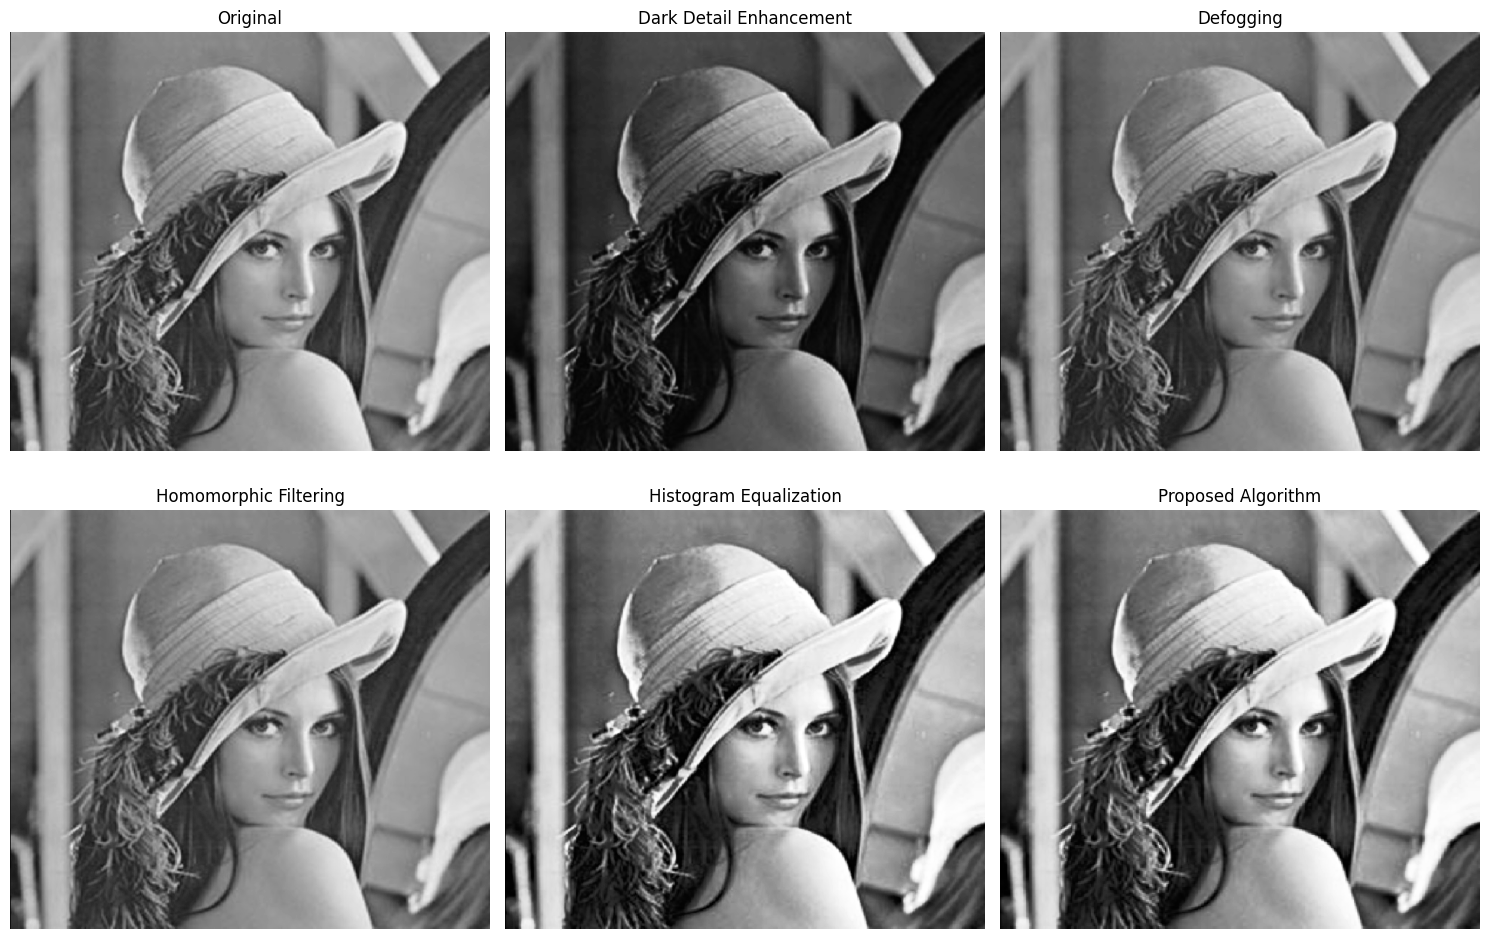

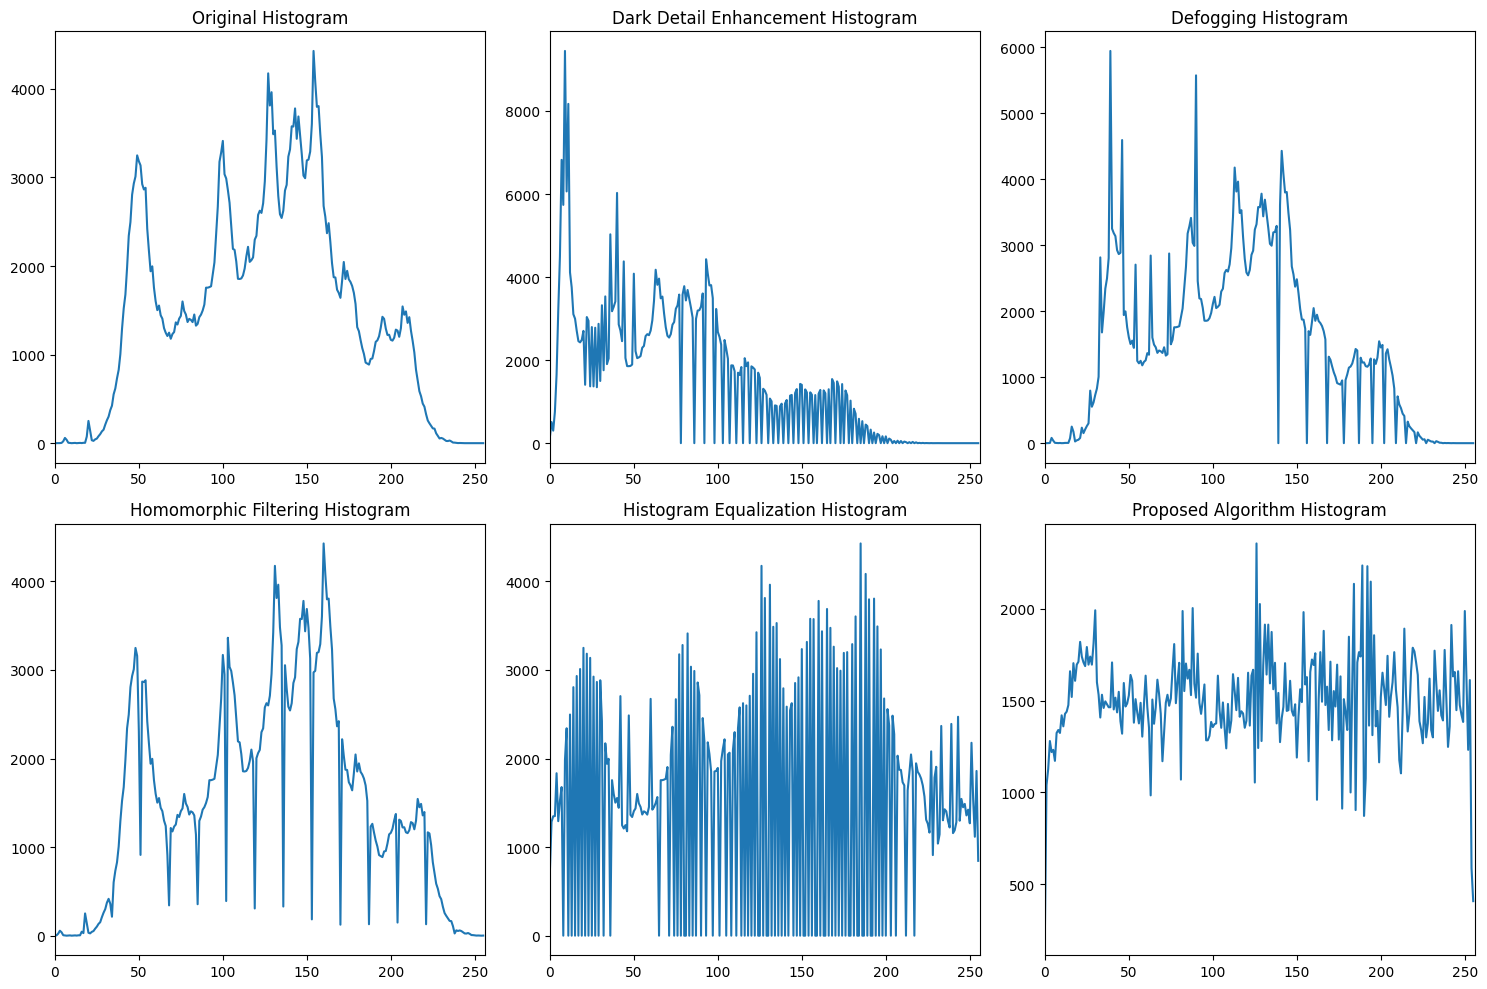

In [73]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def defog_image(image, window_size=15, lambda_=0.2):
    # Convert the image to float
    img = np.array(image, dtype=np.float64) / 255.0

    # Calculate the dark channel
    dark_channel = img  # For grayscale image, the dark channel is the image itself

    # Estimate the atmospheric light
    atmospheric_light = np.max(img)

    # Estimate the transmission
    transmission = 1 - lambda_ * dark_channel / atmospheric_light

    # Guided filter for smoothing the transmission
    mean_transmission = cv2.ximgproc.guidedFilter(
        guide=image.astype(np.float32),
        src=transmission.astype(np.float32),
        radius=window_size,
        eps=0.001,
    )

    # Recover the scene radiance
    recovered_radiance = (img - atmospheric_light) / np.maximum(mean_transmission, lambda_) + atmospheric_light

    # Clip the values to ensure it remains in the valid range
    recovered_radiance = np.clip(recovered_radiance, 0, 1)

    # Convert the image back to uint8
    recovered_radiance = (recovered_radiance * 255).astype(np.uint8)

    return recovered_radiance

def defog(image):
    return defog_image(image)

def histogram_equalization(image):
    return cv2.equalizeHist(image)

def homomorphic_filter(image, gammaH=1.5, gammaL=0.5, c=1, D0=30):
    rows, cols = image.shape
    crow, ccol = int(rows / 2), int(cols / 2)
    X, Y = np.meshgrid(np.arange(cols) - ccol, np.arange(rows) - crow)
    D = np.sqrt(X**2 + Y**2)
    H = (gammaH - gammaL) * (1 - np.exp(-c * (D**2 / D0**2))) + gammaL
    img_fft = np.fft.fft2(image)
    img_fft_filtered = img_fft * H
    img_filtered = np.real(np.fft.ifft2(img_fft_filtered))
    img_filtered = cv2.normalize(img_filtered, None, 0, 255, cv2.NORM_MINMAX)
    return img_filtered

def proposed_algorithm(image):
    equalized_image = histogram_equalization(image)
    homomorphic_image = homomorphic_filter(equalized_image)
    homomorphic_image = cv2.normalize(homomorphic_image, None, 0, 255, cv2.NORM_MINMAX)
    homomorphic_image = np.uint8(homomorphic_image)

    intensity = homomorphic_image.astype(np.float32) / 255.0
    coeffs = pywt.wavedec2(intensity, 'haar', level=1)
    coeffs = list(coeffs)
    coeffs[1] = tuple([pywt.threshold(i, value=0.5, mode='soft') for i in coeffs[1]])
    reconstructed_intensity = pywt.waverec2(coeffs, 'haar')
    reconstructed_intensity = cv2.normalize(reconstructed_intensity, None, 0, 255, cv2.NORM_MINMAX)
    reconstructed_intensity = np.uint8(reconstructed_intensity)
    return reconstructed_intensity

# Load the image
image_path = '/content/drive/MyDrive/i/lena_face.jpg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if original_image is None:
    raise FileNotFoundError("The specified image path does not exist or the image could not be loaded.")

# Process images with different methods
images = {
    'Original': original_image,
    'Dark Detail Enhancement': adjust_gamma(original_image, gamma=0.5),
    'Defogging': defog(original_image),
    'Homomorphic Filtering': homomorphic_filter(original_image),
    'Histogram Equalization': histogram_equalization(original_image),
    'Proposed Algorithm': proposed_algorithm(original_image)
}

# Plotting processed images
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for ax, (title, img) in zip(axes, images.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Histogram Comparison
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for ax, (title, img) in zip(axes, images.items()):
    img = np.uint8(img)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    ax.plot(hist)
    ax.set_title(f'{title}')
    ax.set_xlim([0, 256])

plt.tight_layout()
plt.show()


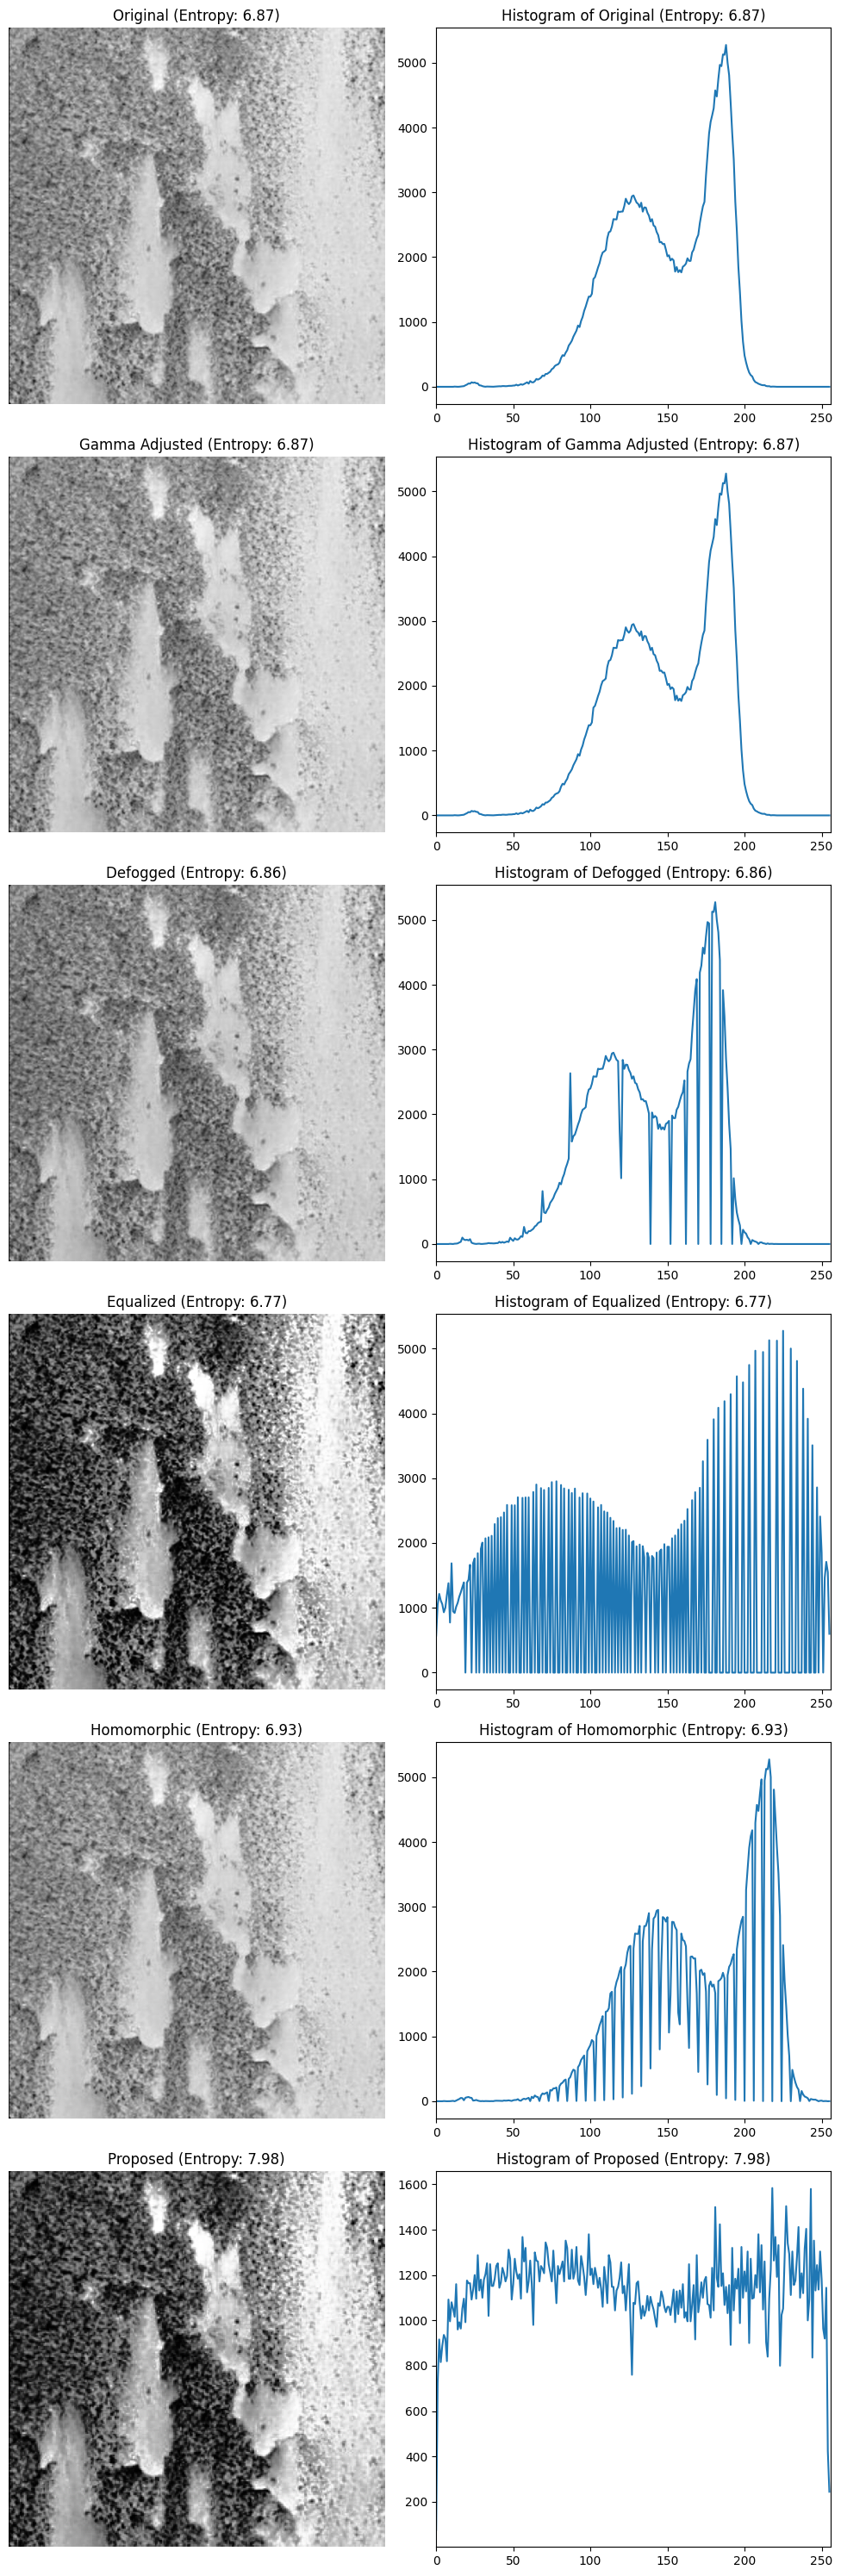

Entropies for Image 1:
Original: 6.87
Gamma Adjusted: 6.87
Defogged: 6.86
Equalized: 6.77
Homomorphic: 6.93
Proposed: 7.98


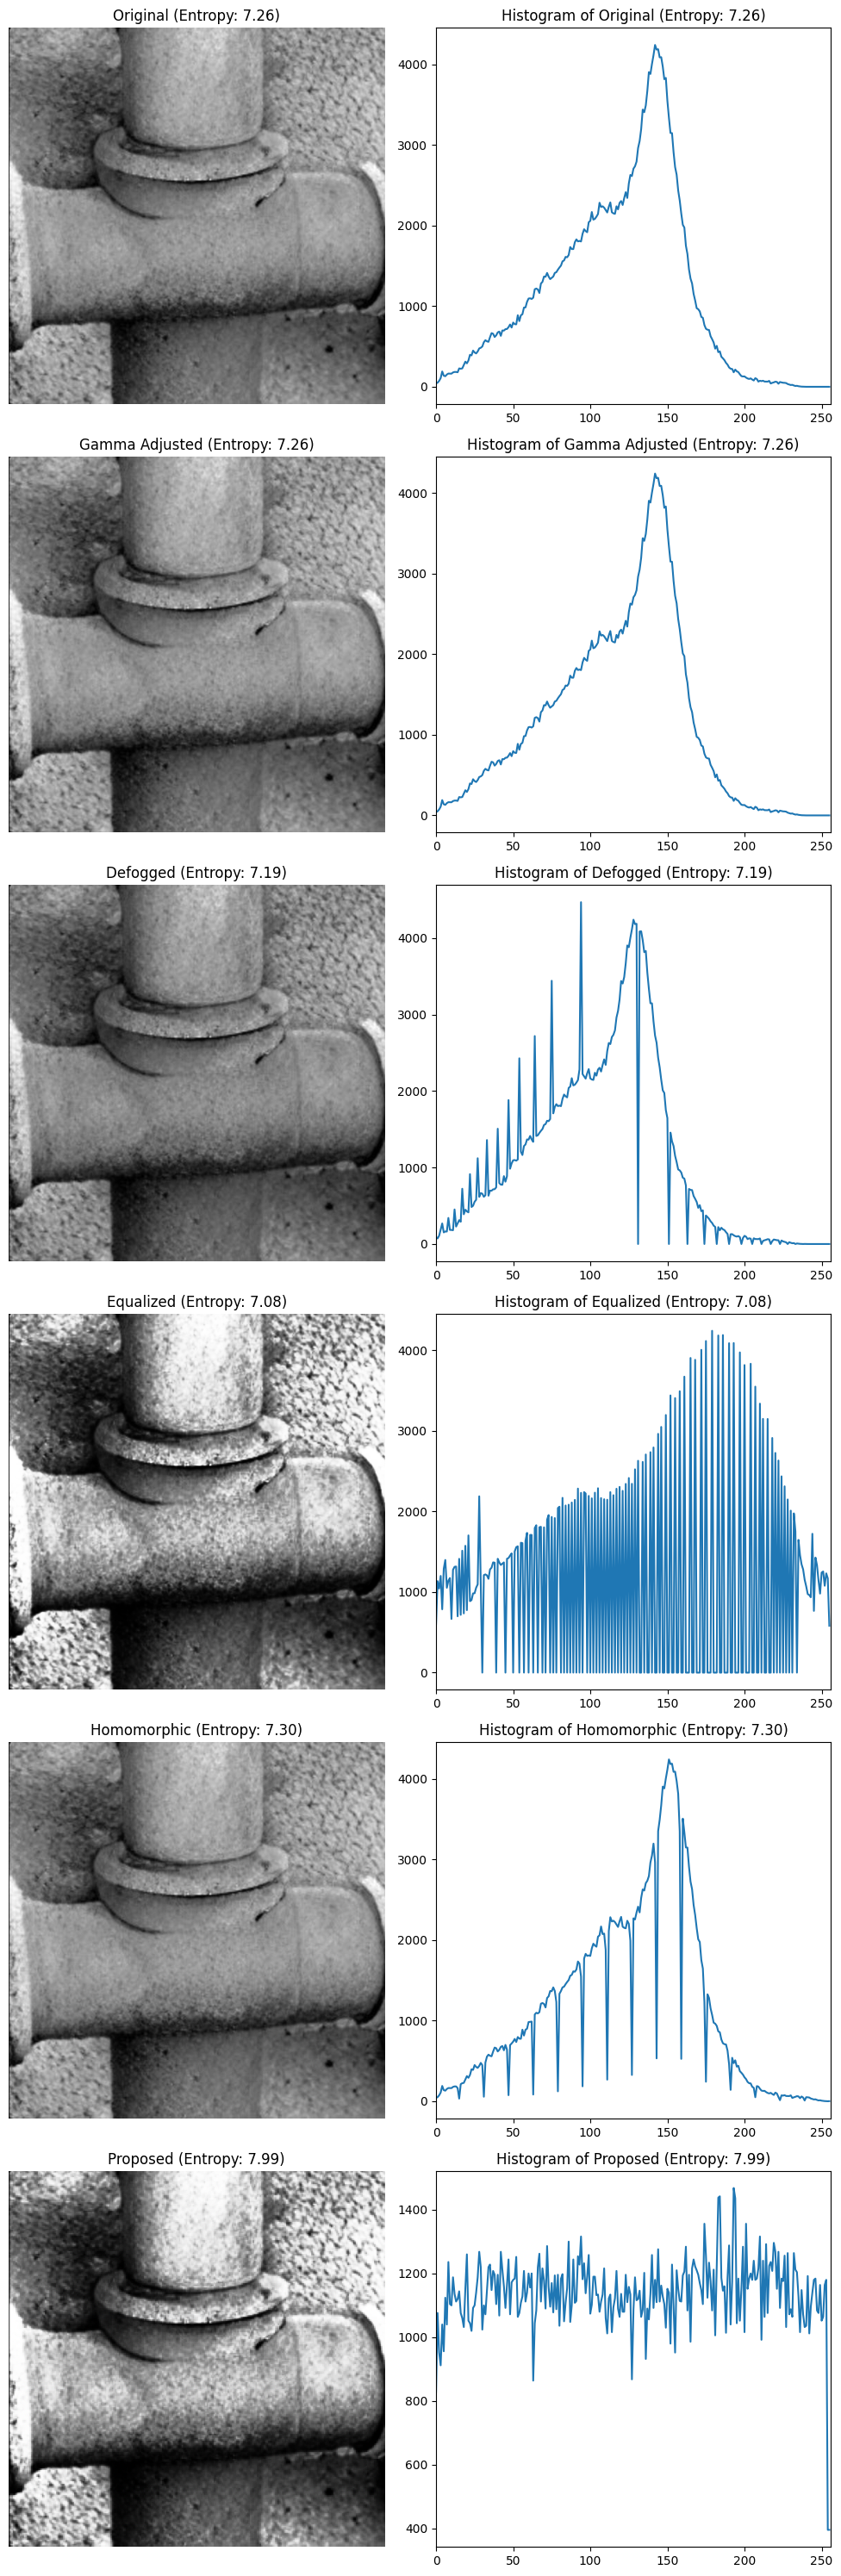

Entropies for Image 2:
Original: 7.26
Gamma Adjusted: 7.26
Defogged: 7.19
Equalized: 7.08
Homomorphic: 7.30
Proposed: 7.99


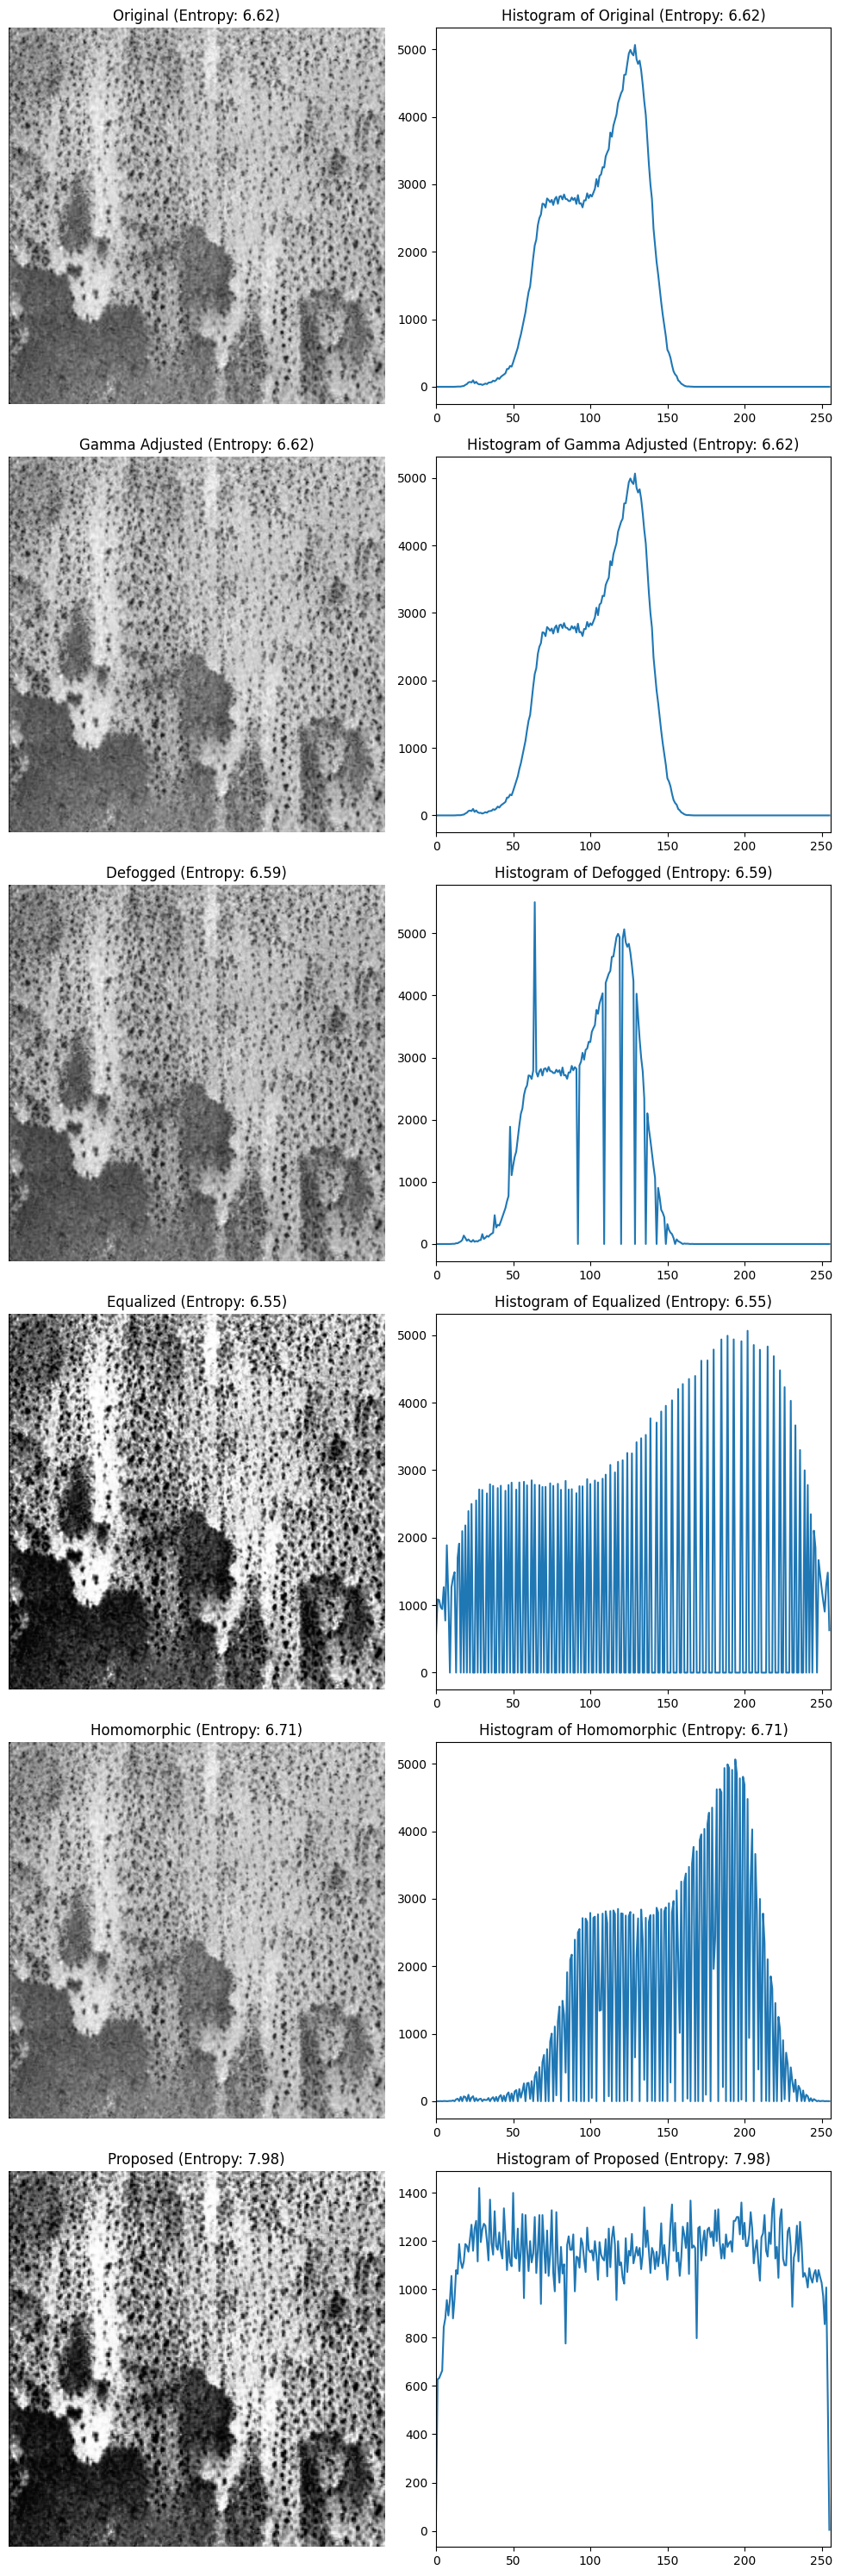

Entropies for Image 3:
Original: 6.62
Gamma Adjusted: 6.62
Defogged: 6.59
Equalized: 6.55
Homomorphic: 6.71
Proposed: 7.98


In [74]:
# EVALUATION METRICS
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
import zipfile
import os
from scipy.stats import entropy

# Load only three images from the specified folder within a zip file
def load_images_from_zip(zip_path, inner_folder, num_images=3):
    """Load a limited number of images from a specified folder within a zip file."""
    images = []
    count = 0
    with zipfile.ZipFile(zip_path, 'r') as z:
        for file in sorted(z.namelist()):
            if file.startswith(inner_folder + '/') and file.endswith('.jpg') and count < num_images:
                data = z.read(file)
                image = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    images.append(image)
                    count += 1
    return images

# Entropy Calculation
def calculate_image_entropy(image):
    """Calculate the entropy of an image."""
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    return -np.sum(hist * np.log2(hist + 1e-10))

# Plotting function for images and histograms
def plot_images_and_histograms(images, titles):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(10, 5 * len(images)))
    if len(images) == 1:
        axes = [axes]

    for ax, image, title in zip(axes, images, titles):
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(title)
        ax[0].axis('off')

        # Convert to uint8 if necessary
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        # Histogram
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        ax[1].plot(hist)
        ax[1].set_title(f'Histogram of {title}')
        ax[1].set_xlim([0, 256])

    plt.tight_layout()
    plt.show()

# Apply enhancement and plot
zip_path = '/content/drive/MyDrive/Synthetic Corrosion Dataset.v3i.folder (3).zip'
test_folder = 'test'
images = load_images_from_zip(zip_path, test_folder, num_images=3)

enhancements = {
    'Original': lambda x: x,
    'Gamma Adjusted': adjust_gamma,
    'Defogged': defog,
    'Equalized': histogram_equalization,
    'Homomorphic': homomorphic_filter,
    'Proposed': proposed_algorithm
}

# Process each image
for idx, image in enumerate(images):
    processed_images = []
    titles = []
    entropies = {'Original': calculate_image_entropy(image)}

    # Apply each enhancement
    for name, func in enhancements.items():
        enhanced_image = func(image.copy())
        entropy_val = calculate_image_entropy(enhanced_image)
        entropies[name] = entropy_val
        processed_images.append(enhanced_image)
        titles.append(f"{name} (Entropy: {entropy_val:.2f})")

    # Plot images and histograms
    plot_images_and_histograms(processed_images, titles)

    # Print entropy table for the current image
    print(f"Entropies for Image {idx + 1}:")
    for enh_name, entropy_value in entropies.items():
        print(f"{enh_name}: {entropy_value:.2f}")
